# Limpeza e Pré-processamento de Dados - Hemograma CBC

**Objetivo:** Limpar e preparar os dados do dataset CBC para análise e modelagem.

## Problemas Identificados na EDA:

1. **Valores biologicamente impossíveis:**
   - Hemoglobina negativa (-10.0)
   - Hemoglobina > 20 g/dL (máximo humano ~20)
   - Hematócrito > 100% (impossível)
   - VCM > 200 fL (impossível)

2. **Unidades incorretas:**
   - WBC e PLT estão em 10³/µL, não em células/µL
   - Precisam ser multiplicados por 1000

3. **Outliers extremos** que vão prejudicar modelos

## Plano de Limpeza:

1. Carregar dados brutos
2. Remover valores negativos
3. Remover valores biologicamente impossíveis
4. Corrigir unidades de WBC e PLT
5. Tratar outliers (winsorização)
6. Validar dados limpos
7. Salvar dataset limpo

## 1. Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("Bibliotecas importadas com sucesso")

✓ Bibliotecas importadas com sucesso!


## 2. Carregar Dados Brutos

In [2]:
# Carregar dataset
df_raw = pd.read_excel('../data/raw/cbc information.xlsx')

print(f"✓ Dataset carregado: {df_raw.shape[0]:,} linhas × {df_raw.shape[1]} colunas")
print(f"\nColunas: {df_raw.columns.tolist()}")

# Salvar tamanho original para comparação
tamanho_original = len(df_raw)

df_raw.head()

✓ Dataset carregado: 500 linhas × 21 colunas

Colunas: ['ID', 'WBC', 'LYMp', 'MIDp', 'NEUTp', 'LYMn', 'MIDn', 'NEUTn', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDWSD', 'RDWCV', 'PLT', 'MPV', 'PDW', 'PCT', 'PLCR']


,ID,WBC,LYMp,MIDp,NEUTp,LYMn,MIDn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,RDWSD,RDWCV,PLT,MPV,PDW,PCT,PLCR
0,1,10.0,43.2,6.7,50.1,4.3,0.7,5.0,2.77,7.3,24.2,87.7,26.3,30.1,35.3,11.4,189.0,9.2,12.5,0.17,22.3
1,2,10.0,42.4,5.3,52.3,4.2,0.5,5.3,2.84,7.3,25.0,88.2,25.7,20.2,35.3,11.4,180.0,8.9,12.5,0.16,19.5
2,3,7.2,30.7,8.6,60.7,2.2,0.6,4.4,3.97,9.0,30.5,77.0,22.6,29.5,37.2,13.7,148.0,10.1,14.3,0.14,30.5
3,4,6.0,30.2,6.3,63.5,1.8,0.4,3.8,4.22,3.8,32.8,77.9,23.2,29.8,46.5,17.0,143.0,8.6,11.3,0.12,16.4
4,5,4.2,39.1,7.2,53.7,1.6,0.3,2.3,3.93,0.4,316.0,80.6,23.9,29.7,42.7,15.1,236.0,19.5,12.8,0.22,24.8


## 3. Análise Inicial - Valores Problemáticos

In [ ]:
# Estatísticas antes da limpeza
print("ESTATÍSTICAS ANTES DA LIMPEZA\n")
print("="*70)

colunas_principais = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']

for col in colunas_principais:
    if col in df_raw.columns:
        print(f"\n{col}:")
        print(f"  Min: {df_raw[col].min():.2f}")
        print(f"  Max: {df_raw[col].max():.2f}")
        print(f"  Média: {df_raw[col].mean():.2f}")
        print(f"  Valores negativos: {(df_raw[col] < 0).sum()}")
        print(f"  Valores zero: {(df_raw[col] == 0).sum()}")

📊 ESTATÍSTICAS ANTES DA LIMPEZA


WBC:
  Min: 0.80
  Max: 45.70
  Média: 7.37
  Valores negativos: 0
  Valores zero: 0

RBC:
  Min: 1.42
  Max: 90.80
  Média: 4.88
  Valores negativos: 0
  Valores zero: 0

HGB:
  Min: -10.00
  Max: 87.10
  Média: 11.74
  Valores negativos: 1
  Valores zero: 0

HCT:
  Min: 2.00
  Max: 3715.00
  Média: 46.15
  Valores negativos: 0
  Valores zero: 0

MCV:
  Min: -79.30
  Max: 990.00
  Média: 82.18
  Valores negativos: 1
  Valores zero: 0

MCH:
  Min: 10.90
  Max: 3117.00
  Média: 37.46
  Valores negativos: 0
  Valores zero: 0

MCHC:
  Min: 11.50
  Max: 92.80
  Média: 30.95
  Valores negativos: 0
  Valores zero: 0

PLT:
  Min: 11.30
  Max: 508.00
  Média: 171.22
  Valores negativos: 0
  Valores zero: 0


## 4. LIMPEZA PASSO A PASSO

### Passo 1: Remover Valores Negativos

In [ ]:
# Criar cópia para trabalhar
df = df_raw.copy()

# Identificar linhas com valores negativos nas colunas principais
mask_negativos = (df[colunas_principais] < 0).any(axis=1)
linhas_com_negativos = mask_negativos.sum()

print(f"Linhas com valores negativos: {linhas_com_negativos} ({linhas_com_negativos/len(df)*100:.2f}%)")

# Remover linhas com valores negativos
df = df[~mask_negativos]

print(f"Foram removidas {linhas_com_negativos} linhas com valores negativos")
print(f"Restam: {len(df):,} linhas")

🔍 Linhas com valores negativos: 2 (0.40%)
✓ Removidas 2 linhas com valores negativos
✓ Restam: 498 linhas


### Passo 2: Definir Limites Biologicamente Plausíveis

In [ ]:
# Definir limites máximos biologicamente plausíveis
# Baseado em literatura médica e valores extremos viáveis

limites_biologicos = {
    'HGB': {'min': 3.0, 'max': 20.0},      # Hemoglobina (g/dL)
    'HCT': {'min': 10.0, 'max': 65.0},     # Hematócrito (%)
    'RBC': {'min': 1.0, 'max': 8.0},       # Eritrócitos (10^6/µL)
    'MCV': {'min': 50.0, 'max': 120.0},    # VCM (fL)
    'MCH': {'min': 20.0, 'max': 40.0},     # HCM (pg)
    'MCHC': {'min': 28.0, 'max': 38.0},    # CHCM (g/dL)
    'WBC': {'min': 0.5, 'max': 100.0},     # Leucócitos (10³/µL) - ainda não convertido
    'PLT': {'min': 10.0, 'max': 1000.0},   # Plaquetas (10³/µL) - ainda não convertido
}

print("Limites Biológicos Definidos:\n")
for marcador, limites in limites_biologicos.items():
    print(f"  {marcador}: {limites['min']} - {limites['max']}")

📋 Limites Biológicos Definidos:

  HGB: 3.0 - 20.0
  HCT: 10.0 - 65.0
  RBC: 1.0 - 8.0
  MCV: 50.0 - 120.0
  MCH: 20.0 - 40.0
  MCHC: 28.0 - 38.0
  WBC: 0.5 - 100.0
  PLT: 10.0 - 1000.0


### Passo 3: Remover Valores Fora dos Limites Biológicos

In [ ]:
# Aplicar filtros por marcador
linhas_antes = len(df)
removidas_por_marcador = {}

for marcador, limites in limites_biologicos.items():
    if marcador in df.columns:
        # Identificar valores fora dos limites
        fora_limites = (df[marcador] < limites['min']) | (df[marcador] > limites['max'])
        n_removidas = fora_limites.sum()
        
        if n_removidas > 0:
            removidas_por_marcador[marcador] = n_removidas
            print(f"\n{marcador}:")
            print(f"  Valores fora dos limites: {n_removidas}")
            print(f"  Min encontrado: {df[marcador].min():.2f}")
            print(f"  Max encontrado: {df[marcador].max():.2f}")
            
            # Remover linhas
            df = df[~fora_limites]

linhas_depois = len(df)
total_removidas = linhas_antes - linhas_depois

print("\n" + "="*70)
print(f"Total removido por limites biológicos: {total_removidas} linhas")
print(f"Restam: {linhas_depois:,} linhas ({linhas_depois/tamanho_original*100:.1f}% do original)")


HGB:
  Valores fora dos limites: 7
  Min encontrado: 0.40
  Max encontrado: 87.10

HCT:
  Valores fora dos limites: 2
  Min encontrado: 10.10
  Max encontrado: 3715.00

RBC:
  Valores fora dos limites: 1
  Min encontrado: 1.42
  Max encontrado: 90.80

MCV:
  Valores fora dos limites: 4
  Min encontrado: 36.60
  Max encontrado: 990.00

MCH:
  Valores fora dos limites: 51
  Min encontrado: 11.40
  Max encontrado: 3117.00

MCHC:
  Valores fora dos limites: 9
  Min encontrado: 20.20
  Max encontrado: 92.80

✓ Total removido por limites biológicos: 74 linhas
✓ Restam: 424 linhas (84.8% do original)


### Passo 4: Corrigir Unidades de WBC e PLT

**IMPORTANTE:** WBC e PLT estão em 10³/µL, mas nossos valores de referência são em células/µL.
Precisamos multiplicar por 1000.

In [ ]:
print("Corrigindo unidades de WBC e PLT...\n")

# Antes
print("ANTES da conversão:")
print(f"  WBC - Min: {df['WBC'].min():.2f}, Max: {df['WBC'].max():.2f}, Média: {df['WBC'].mean():.2f}")
print(f"  PLT - Min: {df['PLT'].min():.2f}, Max: {df['PLT'].max():.2f}, Média: {df['PLT'].mean():.2f}")

# Converter: 10³/µL → células/µL (multiplicar por 1000)
df['WBC'] = df['WBC'] * 1000
df['PLT'] = df['PLT'] * 1000

# Depois
print("\nDEPOIS da conversão:")
print(f"  WBC - Min: {df['WBC'].min():.0f}, Max: {df['WBC'].max():.0f}, Média: {df['WBC'].mean():.0f}")
print(f"  PLT - Min: {df['PLT'].min():.0f}, Max: {df['PLT'].max():.0f}, Média: {df['PLT'].mean():.0f}")

print("\n Unidades convertidas com sucesso!")

🔧 Corrigindo unidades de WBC e PLT...

ANTES da conversão:
  WBC - Min: 2.00, Max: 24.40, Média: 7.23
  PLT - Min: 12.40, Max: 402.00, Média: 166.84

DEPOIS da conversão:
  WBC - Min: 2000, Max: 24400, Média: 7229
  PLT - Min: 12400, Max: 402000, Média: 166838

✓ Unidades convertidas com sucesso!


### Passo 5: Aplicar Novos Limites Após Conversão

In [ ]:
# Limites corrigidos após conversão de unidades
limites_pos_conversao = {
    'WBC': {'min': 500, 'max': 100000},      # Leucócitos (células/µL)
    'PLT': {'min': 10000, 'max': 1000000},   # Plaquetas (células/µL)
}

linhas_antes = len(df)

for marcador, limites in limites_pos_conversao.items():
    if marcador in df.columns:
        fora_limites = (df[marcador] < limites['min']) | (df[marcador] > limites['max'])
        n_removidas = fora_limites.sum()
        
        if n_removidas > 0:
            print(f"\n{marcador}: {n_removidas} valores fora dos novos limites")
            df = df[~fora_limites]

linhas_depois = len(df)
print(f"\n Removidas {linhas_antes - linhas_depois} linhas adicionais")
print(f"Restam: {linhas_depois:,} linhas")


✓ Removidas 0 linhas adicionais
✓ Restam: 424 linhas


### Passo 6: Tratar Outliers Remanescentes (Winsorização)

Mesmo após remover valores impossíveis, ainda podem existir outliers extremos.
Vamos usar **winsorização** para "capeá-los" nos percentis 1% e 99%.

In [ ]:
from scipy.stats.mstats import winsorize

print("Aplicando Winsorização (cap nos percentis 1% e 99%)...\n")

# Colunas para winsorizar
colunas_winsorize = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']

for col in colunas_winsorize:
    if col in df.columns:
        antes_min = df[col].min()
        antes_max = df[col].max()
        
        # Winsorizar: limitar aos percentis 1% e 99%
        df[col] = winsorize(df[col], limits=[0.01, 0.01])
        
        depois_min = df[col].min()
        depois_max = df[col].max()
        
        if antes_min != depois_min or antes_max != depois_max:
            print(f"{col}:")
            print(f"  Antes: [{antes_min:.2f}, {antes_max:.2f}]")
            print(f"  Depois: [{depois_min:.2f}, {depois_max:.2f}]")

print("\n Winsorização concluída")

🔧 Aplicando Winsorização (cap nos percentis 1% e 99%)...

WBC:
  Antes: [2000.00, 24400.00]
  Depois: [2400.00, 17100.00]
RBC:
  Antes: [1.42, 5.99]
  Depois: [2.55, 5.77]
HGB:
  Antes: [3.10, 17.50]
  Depois: [5.90, 15.90]
HCT:
  Antes: [10.10, 53.30]
  Depois: [23.60, 49.80]
MCV:
  Antes: [64.10, 106.20]
  Depois: [68.80, 95.20]
MCH:
  Antes: [20.00, 34.20]
  Depois: [20.10, 31.70]
MCHC:
  Antes: [28.00, 35.70]
  Depois: [28.30, 34.10]
PLT:
  Antes: [12400.00, 402000.00]
  Depois: [69000.00, 312000.00]

✓ Winsorização concluída!


## 5. Validação dos Dados Limpos

In [ ]:
print("="*70)
print(" RESUMO DA LIMPEZA")
print("="*70)

print(f"\nTamanho do Dataset:")
print(f"  Original: {tamanho_original:,} linhas")
print(f"  Final: {len(df):,} linhas")
print(f"  Removidas: {tamanho_original - len(df):,} linhas ({(tamanho_original - len(df))/tamanho_original*100:.1f}%)")
print(f"  Mantidas: {len(df)/tamanho_original*100:.1f}%")

print(f"\n Validações:")
print(f"  • Valores negativos: {(df[colunas_principais] < 0).sum().sum()}")
print(f"  • Valores faltantes: {df[colunas_principais].isnull().sum().sum()}")

print(f"\n📊 Estatísticas Finais das Principais Variáveis:\n")
df[colunas_principais].describe().T[['min', 'max', 'mean', 'std']].round(2)

📊 RESUMO DA LIMPEZA

📈 Tamanho do Dataset:
  Original: 500 linhas
  Final: 424 linhas
  Removidas: 76 linhas (15.2%)
  Mantidas: 84.8%

✅ Validações:
  • Valores negativos: 0
  • Valores faltantes: 0

📊 Estatísticas Finais das Principais Variáveis:



,min,max,mean,std
WBC,2400.00,17100.00,7185.38,2913.26
RBC,2.55,5.77,4.56,0.62
HGB,5.90,15.90,11.78,2.01
HCT,23.60,49.80,37.82,5.31
MCV,68.80,95.20,82.84,5.78
MCH,20.10,31.70,25.74,2.50
MCHC,28.30,34.10,31.06,1.31
PLT,69000.00,312000.00,166762.03,46090.11


## 6. Visualização: Antes vs Depois

✓ Gráfico salvo: reports/figures/00_antes_depois_limpeza.png


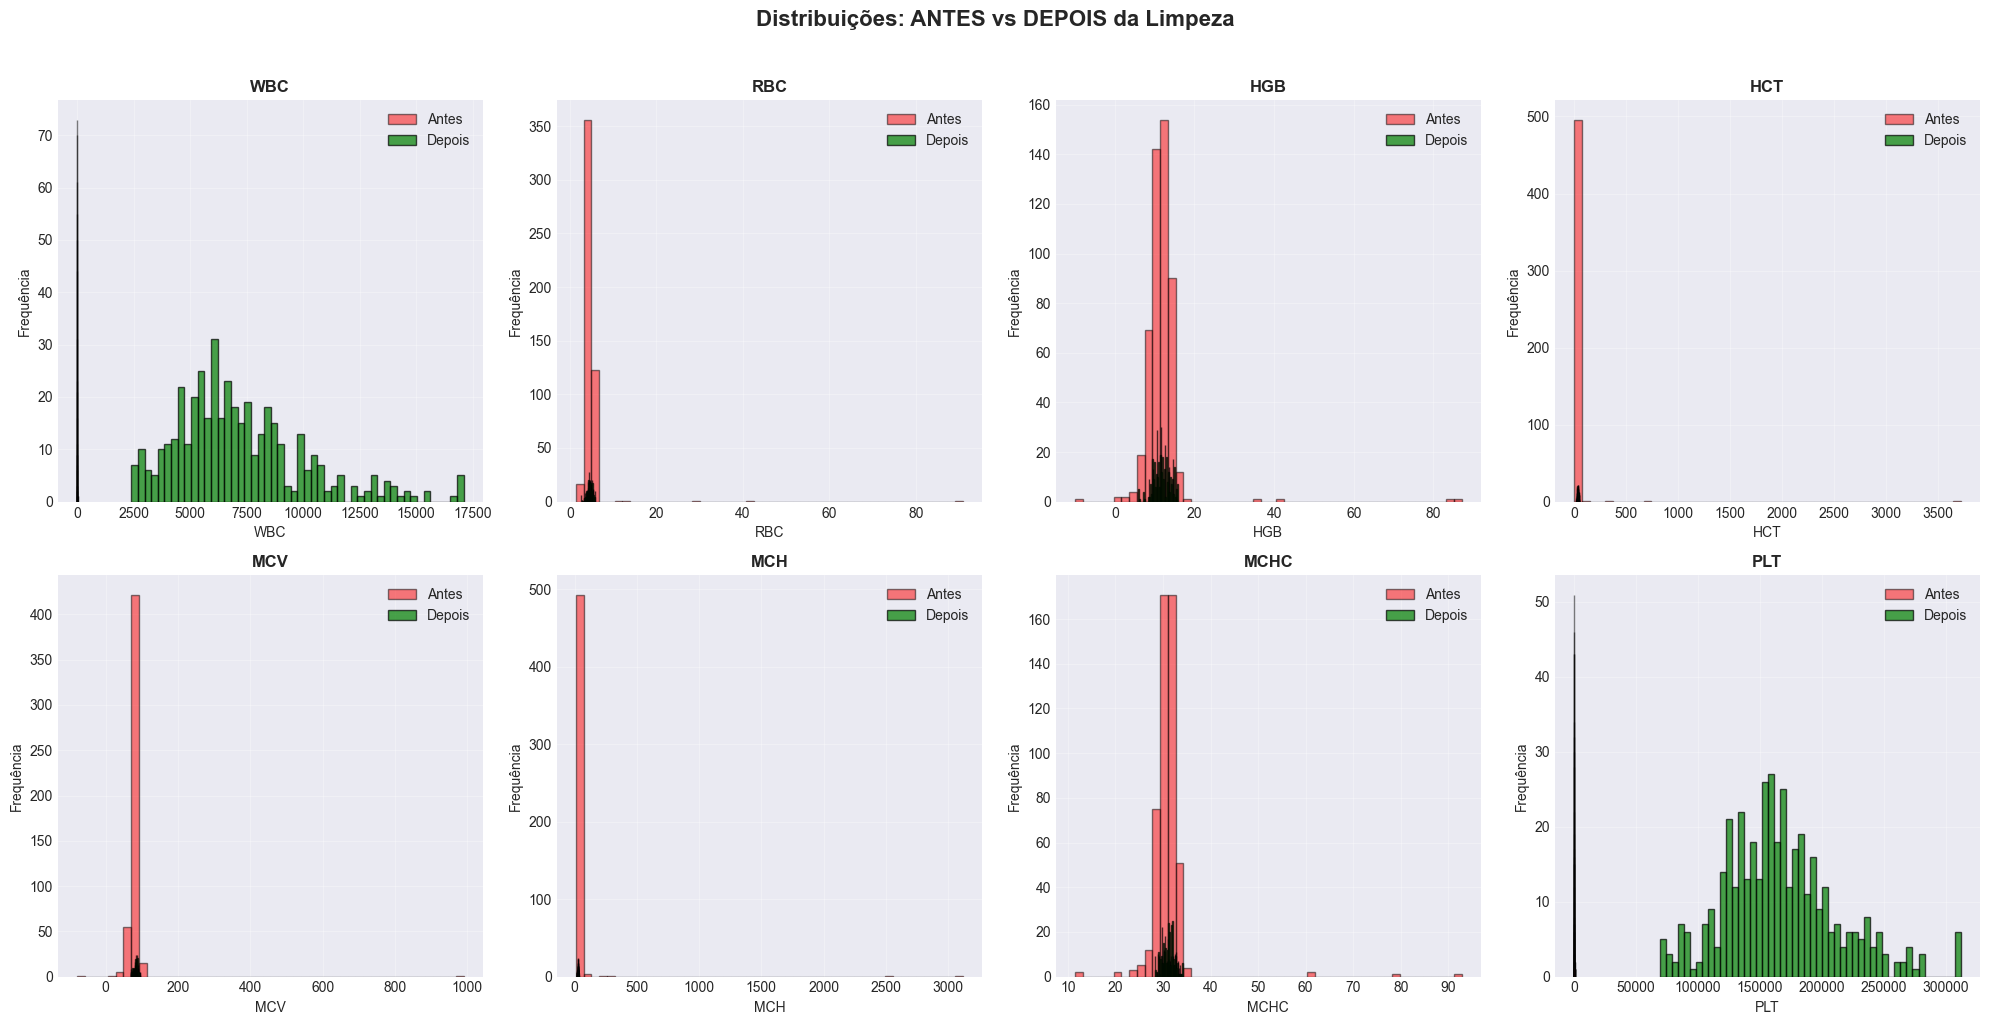

In [ ]:
# Comparar distribuições antes e depois
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(colunas_principais):
    ax = axes[idx]
    
    # Antes (raw)
    ax.hist(df_raw[col].dropna(), bins=50, alpha=0.5, label='Antes', color='red', edgecolor='black')
    
    # Depois (limpo)
    ax.hist(df[col].dropna(), bins=50, alpha=0.7, label='Depois', color='green', edgecolor='black')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuições: ANTES vs DEPOIS da Limpeza', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/00_antes_depois_limpeza.png', dpi=300, bbox_inches='tight')
print("Gráfico salvo: reports/figures/00_antes_depois_limpeza.png")
plt.show()

## 7. Atualizar Valores de Referência para Dataset Limpo

In [ ]:
# Valores de referência clínicos CORRETOS (com unidades corretas)
valores_referencia_corrigidos = {
    'HGB': {'min': 12.0, 'max': 16.0, 'unidade': 'g/dL', 'nome': 'Hemoglobina'},
    'HCT': {'min': 36.0, 'max': 48.0, 'unidade': '%', 'nome': 'Hematócrito'},
    'RBC': {'min': 4.0, 'max': 5.5, 'unidade': '10⁶/µL', 'nome': 'Eritrócitos'},
    'MCV': {'min': 80.0, 'max': 100.0, 'unidade': 'fL', 'nome': 'VCM'},
    'MCH': {'min': 27.0, 'max': 32.0, 'unidade': 'pg', 'nome': 'HCM'},
    'MCHC': {'min': 32.0, 'max': 36.0, 'unidade': 'g/dL', 'nome': 'CHCM'},
    'WBC': {'min': 4000, 'max': 11000, 'unidade': 'células/µL', 'nome': 'Leucócitos'},
    'PLT': {'min': 150000, 'max': 400000, 'unidade': 'células/µL', 'nome': 'Plaquetas'},
}

# Verificar porcentagem dentro/fora da referência
print("Análise com Valores de Referência CORRETOS:\n")
print("="*70)

for marcador, ref in valores_referencia_corrigidos.items():
    if marcador in df.columns:
        abaixo = (df[marcador] < ref['min']).sum()
        normal = ((df[marcador] >= ref['min']) & (df[marcador] <= ref['max'])).sum()
        acima = (df[marcador] > ref['max']).sum()
        
        print(f"\n{ref['nome']} ({marcador}):")
        print(f"  Referência: {ref['min']} - {ref['max']} {ref['unidade']}")
        print(f"  ⬇️ Abaixo: {abaixo} ({abaixo/len(df)*100:.1f}%)")
        print(f"  ✅ Normal: {normal} ({normal/len(df)*100:.1f}%)")
        print(f"  ⬆️ Acima: {acima} ({acima/len(df)*100:.1f}%)")

📋 Análise com Valores de Referência CORRETOS:


Hemoglobina (HGB):
  Referência: 12.0 - 16.0 g/dL
  ⬇️ Abaixo: 237 (55.9%)
  ✅ Normal: 187 (44.1%)
  ⬆️ Acima: 0 (0.0%)

Hematócrito (HCT):
  Referência: 36.0 - 48.0 %
  ⬇️ Abaixo: 150 (35.4%)
  ✅ Normal: 263 (62.0%)
  ⬆️ Acima: 11 (2.6%)

Eritrócitos (RBC):
  Referência: 4.0 - 5.5 10⁶/µL
  ⬇️ Abaixo: 69 (16.3%)
  ✅ Normal: 337 (79.5%)
  ⬆️ Acima: 18 (4.2%)

VCM (MCV):
  Referência: 80.0 - 100.0 fL
  ⬇️ Abaixo: 118 (27.8%)
  ✅ Normal: 306 (72.2%)
  ⬆️ Acima: 0 (0.0%)

HCM (MCH):
  Referência: 27.0 - 32.0 pg
  ⬇️ Abaixo: 279 (65.8%)
  ✅ Normal: 145 (34.2%)
  ⬆️ Acima: 0 (0.0%)

CHCM (MCHC):
  Referência: 32.0 - 36.0 g/dL
  ⬇️ Abaixo: 318 (75.0%)
  ✅ Normal: 106 (25.0%)
  ⬆️ Acima: 0 (0.0%)

Leucócitos (WBC):
  Referência: 4000 - 11000 células/µL
  ⬇️ Abaixo: 38 (9.0%)
  ✅ Normal: 346 (81.6%)
  ⬆️ Acima: 40 (9.4%)

Plaquetas (PLT):
  Referência: 150000 - 400000 células/µL
  ⬇️ Abaixo: 154 (36.3%)
  ✅ Normal: 270 (63.7%)
  ⬆️ Acima: 0 (0.0%)

## 8. Salvar Dataset Limpo

In [ ]:
# Salvar dataset limpo
output_path = '../data/processed/cbc_limpo.csv'
df.to_csv(output_path, index=False)

print("="*70)
print("DATASET LIMPO SALVO COM SUCESSO!")
print("="*70)
print(f"\n Arquivo: {output_path}")
print(f" Dimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"\n Próximos passos:")
print("  1. Use este dataset limpo nos próximos notebooks")
print("  2. Execute 01_eda.ipynb novamente com os dados limpos")
print("  3. Prossiga para detecção de anomalias")

# Também salvar em Excel para fácil visualização
df.to_excel('../data/processed/cbc_limpo.xlsx', index=False)
print("\n Também salvo em Excel: data/processed/cbc_limpo.xlsx")

💾 DATASET LIMPO SALVO COM SUCESSO!

📂 Arquivo: ../data/processed/cbc_limpo.csv
📊 Dimensões: 424 linhas × 21 colunas

✅ Próximos passos:
  1. Use este dataset limpo nos próximos notebooks
  2. Execute 01_eda.ipynb novamente com os dados limpos
  3. Prossiga para detecção de anomalias

✓ Também salvo em Excel: data/processed/cbc_limpo.xlsx


## 9. Resumo da Limpeza - Para Documentação

In [14]:
resumo = f"""
═══════════════════════════════════════════════════════════════════════
📋 RESUMO DA LIMPEZA DE DADOS - CBC DATASET
═══════════════════════════════════════════════════════════════════════

📊 DATASET ORIGINAL:
   • Linhas: {tamanho_original:,}
   • Colunas: {df_raw.shape[1]}

🧹 AÇÕES REALIZADAS:
   1. Remoção de valores negativos
   2. Remoção de valores biologicamente impossíveis
   3. Conversão de unidades (WBC e PLT: 10³/µL → células/µL)
   4. Aplicação de limites biológicos plausíveis
   5. Winsorização de outliers (percentis 1% e 99%)

📊 DATASET FINAL:
   • Linhas: {len(df):,}
   • Colunas: {df.shape[1]}
   • Taxa de retenção: {len(df)/tamanho_original*100:.1f}%
   • Linhas removidas: {tamanho_original - len(df):,} ({(tamanho_original - len(df))/tamanho_original*100:.1f}%)

✅ VALIDAÇÕES:
   • Valores negativos: 0
   • Valores impossíveis: 0
   • Valores faltantes: {df[colunas_principais].isnull().sum().sum()}
   • Unidades corretas: ✓

💾 ARQUIVO SALVO:
   • CSV: data/processed/cbc_limpo.csv
   • Excel: data/processed/cbc_limpo.xlsx

═══════════════════════════════════════════════════════════════════════
"""

print(resumo)

# Salvar resumo em arquivo
with open('../reports/resumo_limpeza.txt', 'w', encoding='utf-8') as f:
    f.write(resumo)

print("\n✓ Resumo salvo em: reports/resumo_limpeza.txt")


═══════════════════════════════════════════════════════════════════════
📋 RESUMO DA LIMPEZA DE DADOS - CBC DATASET
═══════════════════════════════════════════════════════════════════════

📊 DATASET ORIGINAL:
   • Linhas: 500
   • Colunas: 21

🧹 AÇÕES REALIZADAS:
   1. Remoção de valores negativos
   2. Remoção de valores biologicamente impossíveis
   3. Conversão de unidades (WBC e PLT: 10³/µL → células/µL)
   4. Aplicação de limites biológicos plausíveis
   5. Winsorização de outliers (percentis 1% e 99%)

📊 DATASET FINAL:
   • Linhas: 424
   • Colunas: 21
   • Taxa de retenção: 84.8%
   • Linhas removidas: 76 (15.2%)

✅ VALIDAÇÕES:
   • Valores negativos: 0
   • Valores impossíveis: 0
   • Valores faltantes: 0
   • Unidades corretas: ✓

💾 ARQUIVO SALVO:
   • CSV: data/processed/cbc_limpo.csv
   • Excel: data/processed/cbc_limpo.xlsx

═══════════════════════════════════════════════════════════════════════


✓ Resumo salvo em: reports/resumo_limpeza.txt
